In [1]:
#reference: http://brandonrose.org/clustering
import os, sys, re, csv
import heapq
import string
import gensim
import itertools
import json
from operator import itemgetter
import nltk
from nltk import *
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

In [2]:
def get_meta():
    contents = []
    with open("/Users/dariaulybina/Desktop/georgetown/ml_practice/imf_direct/blogs_cleaned.json") as df:
        data2 = json.load(df)
        df.close()
    for d in data2:
        contents.append(d['content'])
    path1 = '/Users/dariaulybina/Desktop/georgetown/ml_practice/imf_direct/metadata_blogs.json'
    with open(path1) as datafile:
        data = json.load(datafile)
        datafile.close()
    return contents,data

In [17]:
# saving metadata to dictionary to use later for hashing search methods:
# structure: {'filename.txt':{'date':'x/x/xxxx','title':'xxx'}}
contents,data = get_meta()
dates = []
titles = []
ides = []
dict_main = {}
for d in data:
    ides.append(d['id'])
    titles.append(d['title'])
    dates.append(d['date'])
    naming = d['id']+'.txt'
    dict1 = {naming:{'date':d['date'],'title':d['title']}}
    dict_main.update(dict1)

In [4]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [5]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [6]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in contents:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [9]:
import pandas as pd
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are {} items in vocab_frame'.format(str(vocab_frame.shape[0])))

there are 587627 items in vocab_frame


In [44]:
print(vocab_frame.head())

         words
by          by
vitor    vitor
gaspar  gaspar
and        and
laura    laura


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,5))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(contents) #fit the vectorizer to contents

print(tfidf_matrix.shape)

CPU times: user 24.9 s, sys: 397 ms, total: 25.3 s
Wall time: 25.5 s
(796, 274)


In [13]:
terms = tfidf_vectorizer.get_feature_names()

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [15]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 6.33 s, sys: 30.7 ms, total: 6.36 s
Wall time: 6.4 s


In [16]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

#joblib.dump(km,  'blogs5_cluster.pkl')

km = joblib.load('blogs5_cluster.pkl')
clusters = km.labels_.tolist()

In [18]:
blogs = { 'title': titles , 'id': ides, 'text': contents, 'cluster': clusters, 'date': dates }

frame = pd.DataFrame(blogs, index = [clusters] , columns = ['title','id','text','cluster','date'])

In [19]:
frame['cluster'].value_counts()

4    209
2    193
3    167
0    142
1     85
Name: cluster, dtype: int64

In [21]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    #print("Cluster %d titles:" % i, end='')
    #for title in frame.ix[i]['title'].values.tolist():
        #print(' %s,' % title, end='')
   # print() #add whitespace
   # print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'price', b'growth', b'regional', b'exports', b'china', b'global',

Cluster 1 words: b'fiscal', b'debts', b'growth', b'deficits', b'policies', b'adjust',

Cluster 2 words: b'growth', b'tax', b'labor', b'investment', b'percent', b'productivity',

Cluster 3 words: b'imf', b'global', b'world', b'meeting', b'crisis', b'imf',

Cluster 4 words: b'banks', b'financial', b'policies', b'rates', b'markets', b'risk',





In [22]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [24]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'price, growth, regional, exports, china, global', 
                 1: 'fiscal, debts, growth, deficits, policies, adjust',
                 2: 'growth, tax, labor, investment, percent, productivity', 
                 3: 'imf, global, world, meeting, crisis', 
                 4: 'banks, financial, policies, rates, markets, risk'}

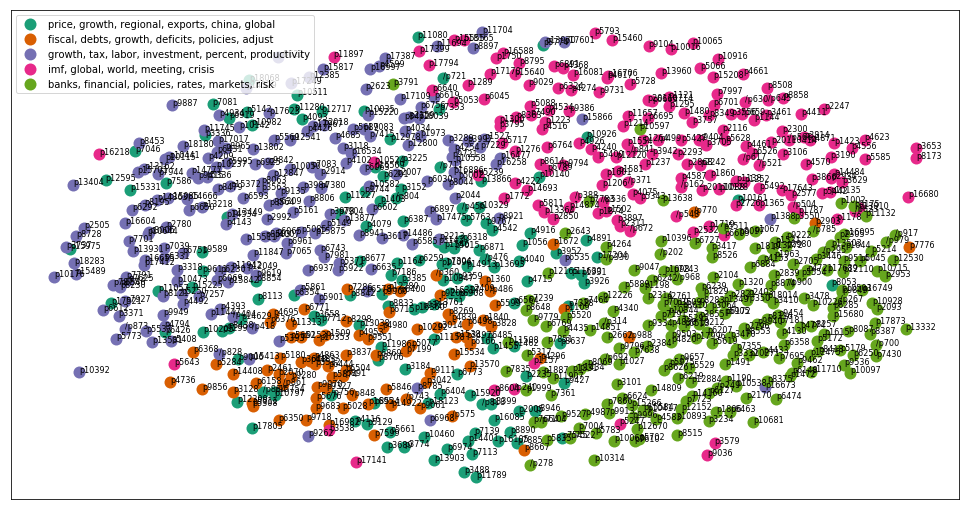

In [27]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and id
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=ides)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)

In [28]:
plt.close()

In [30]:
#define custom toolbar location
import mpld3
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

### Hover over clustered chart (titles displayed!)

In [33]:

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

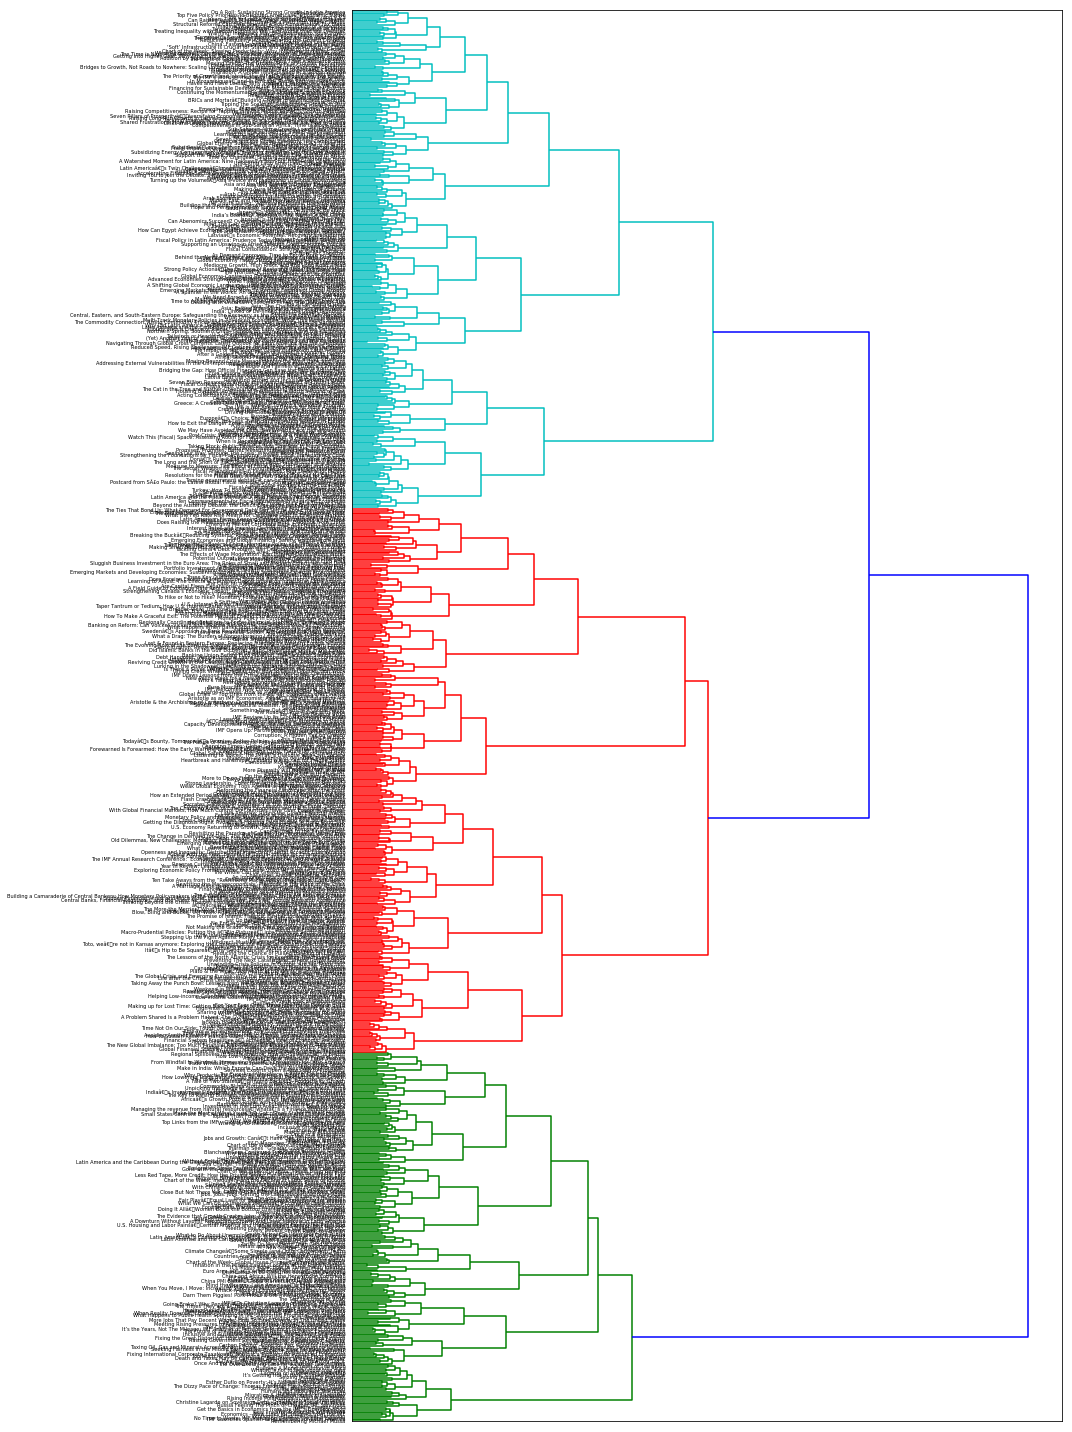

In [34]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [35]:
#strip any proper names from a text
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [36]:
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [39]:
from gensim import corpora, models, similarities 

# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in contents]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 7.2 s, sys: 63.2 ms, total: 7.26 s
Wall time: 7.39 s
CPU times: user 11.4 s, sys: 66.8 ms, total: 11.4 s
Wall time: 11.5 s
CPU times: user 1.02 s, sys: 10.9 ms, total: 1.03 s
Wall time: 1.04 s


In [40]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

### LDA - takes long time to run - not performed yet

In [43]:
%time lda = models.LdaModel(corpus, num_topics=5,id2word=dictionary,update_every=5,chunksize=10000,passes=100)

KeyboardInterrupt: 

In [ ]:
lda.show_topics()

In [ ]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()